In [25]:
import numpy as np
import matplotlib.pyplot as plt


In [26]:
def f_true(x):
    return 0.03 * x ** 4 - 0.4 * x ** 2 + 0.7 * np.sin(2.2 * x)

def make_poly_features(x, degree):
    x = np.asarray(x).reshape(-1, 1)
    X = np.hstack([x ** i for i in range(degree + 1)])
    return X

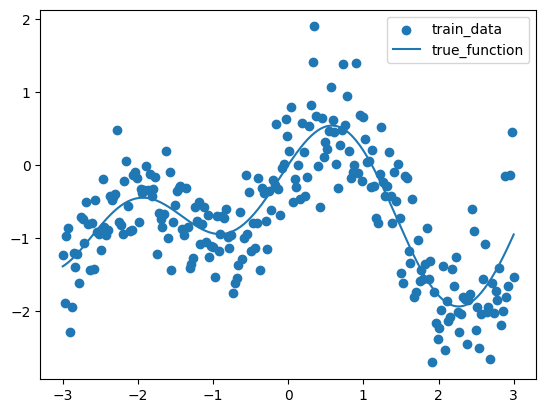

In [27]:
rng = np.random.default_rng(42)

N = 250
x = np.linspace(-3, 3, N)

sigma = 0.5
y = f_true(x) + rng.normal(0, sigma, size=x.shape)

degree = 15
X = make_poly_features(x, degree)

plt.scatter(x, y, label='train_data')
plt.plot(x, f_true(x), label='true_function')
plt.legend()
plt.show()

In [28]:
lamb = 1
alpha = 1.0 / (sigma ** 2)

M = X.shape[1]
posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)

In [29]:
posterior_cov = np.linalg.inv(posterior_cov_inv)
mean = alpha * posterior_cov @ (X.T @ y)

In [30]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)

mean_pred = X_new @ mean
var_pred = 1.0 / alpha + np.sum(X_new @ posterior_cov @ X_new.T, axis=1)
std_pred = np.sqrt(var_pred)

In [31]:
def get_mean_pred(lamb, sigma, X):
    alpha = 1.0 / (sigma ** 2)
    M = X.shape[1]
    posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)
    posterior_cov = np.linalg.inv(posterior_cov_inv)
    mean = alpha * posterior_cov @ (X.T @ y)
    
    mean_pred = X_new @ mean
    return mean_pred
    
    var_pred = 1.0 / alpha + np.sum(X_new @ posterior_cov @ X_new.T, axis=1)
    std_pred = np.sqrt(var_pred)

def get_std_pred(lamb, sigma, X):
    alpha = 1.0 / (sigma ** 2)
    M = X.shape[1]
    posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)
    posterior_cov = np.linalg.inv(posterior_cov_inv)
    var_pred = 1.0 / alpha + np.sum(X_new @ posterior_cov @ X_new.T, axis=1)
    std_pred = np.sqrt(var_pred)
    return std_pred

In [32]:
mean_pred = get_mean_pred(1.0, sigma, X)
std_pred = get_std_pred(1.0, sigma, X)

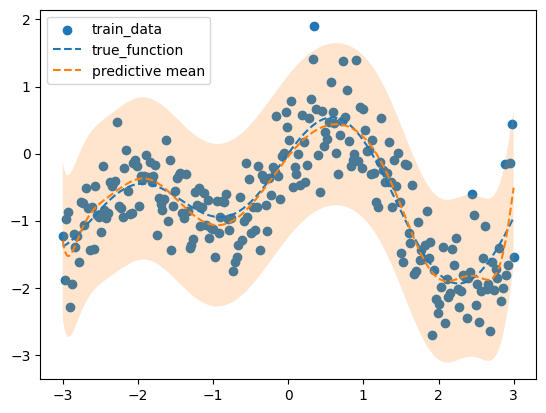

In [33]:
plt.scatter(x, y, label='train_data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function')
plt.plot(x_new, mean_pred, linestyle='--', label='predictive mean')

plt.fill_between(x_new, mean_pred - 1.5 * std_pred, mean_pred + 1.5 * std_pred, alpha=0.2)

plt.legend()
plt.show()

In [34]:

# Тут надо написать расчет log-evidence, через формулу, которая была в лекции
# Далее взять какой-то набор лямбд (например np.logspace(-6, 3, 160)) и оценить для каждой эту функцию
# Получится лучшая лябмда
# Вывести график log-evidence vs lambda + графики, чтобы визуально сравнить предсказания базовой модели и модели с лучшей лямбдой


/tmp/ipykernel_27312/1560710582.py:4: RuntimeWarning: invalid value encountered in log
  return -1.0/2 * (N * np.log(2*np.pi) + np.log(np.linalg.det(C)) + (y.T @ np.linalg.inv(C) @ y))


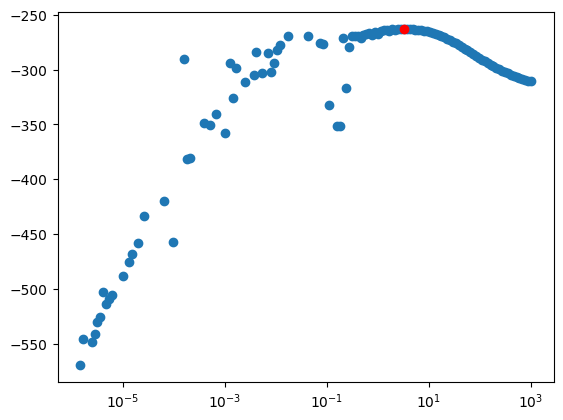

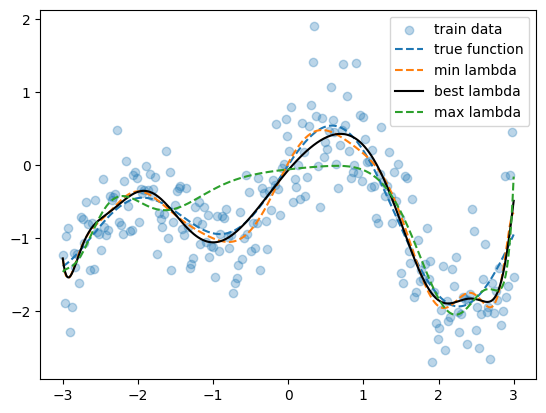

In [35]:
def log_evidence(lamb, X, y, alpha):
    C = 1.0 / alpha * np.eye(N) + 1 / (alpha * lamb) * (X @ X.T)
    #sign, logdet = np.linalg.slogdet(C)
    return -1.0/2 * (N * np.log(2*np.pi) + np.log(np.linalg.det(C)) + (y.T @ np.linalg.inv(C) @ y))


lambdas = np.logspace(-6, 3, 160)
evids = np.empty(160)
best_lamb = best_evid = -4242

for i in range(160):
    evids[i] = log_evidence(lambdas[i], X, y, alpha)
    if (evids[i] > best_evid):
        best_lamb = lambdas[i]
        best_evid = evids[i]
        
plt.scatter(lambdas, evids, label='evidences')
plt.scatter(best_lamb, best_evid, color="red", label='best lambda')
plt.xscale('log')
plt.show()

plt.scatter(x, y, alpha=0.3, label='train data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true function')
plt.plot(x_new, get_mean_pred(lambdas[0], sigma, X), linestyle='--', label='min lambda')
plt.plot(x_new, get_mean_pred(best_lamb, sigma, X), color="black", label='best lambda')
plt.plot(x_new, get_mean_pred(lambdas[-1], sigma, X), linestyle='--', label='max lambda')


plt.legend()
plt.show()


## Интуиция: 
    + Чем меньше лямбда, тем больше "подвижность" кривой
    + Log-evidence выбрал хорошую лямбду, но нужно что-то сделать с шумом при малых значениях
    
    - Но предсказанная функция не совпадает с реальной. Видно, как все три функции на графике переобучились под шум (отдельное внимание на max lambda - сначала не проходит через точки рядом с (-1,-1), а рядом с (2.5,-2) делает непонятный изгиб)
    - Непонятно, почему разброс данных (sigma) достоверно известен заранее, на реальных даных мы же не сможем его достоверно посчитать (будем подбирать?)
    - Нет интуитивного понимания всех формул (или с математикой у меня так себе)
    